In [1]:
import pandas as pd
import numpy as np
import geopandas as geo
import matplotlib.pyplot as plt
import urllib.request
import datetime as dt

In [2]:
# set display widht and length

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 110)

**Merge Water_final and cmc_benthic datasets**

In [6]:
# read in cmc_benthic data
benthic = pd.read_csv('/Users/bibor/Hack_the_Bay/Data/Merged_Benthic.csv', low_memory=False)

In [13]:
# read in cbp_benthic data
cbp = pd.read_csv('/Users/bibor/Hack_the_Bay/Data/CBP_Benthic_clean.csv', low_memory=False, parse_dates=[['Date', 'Time']])

In [3]:
# read in water quality data
wq = data = pd.read_csv('~/Hack_the_Bay/Data/Water_FINAL.csv', low_memory=False, parse_dates=[['Date', 'Time']])

#source for parse_dates: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas

In [30]:
wq.shape

(2708717, 73)

In [6]:
wq.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [28]:
# drop columns where non-null count is less than 100
wq.drop(['BiasPC', 'FieldActivityRemark', 'PrecisionPC'], axis=1, inplace=True)

In [34]:
# transform benthic['SAMPLE_DATE'] into datetime object
benthic['SAMPLE_DATE'] = pd.to_datetime(benthic['SAMPLE_DATE'])

**Merge Water Quality and Benthic data**

In [120]:
# assure that all Latitude and Longitude values are in same decimal format
wq['Longitude'] = wq['Longitude'].round(6)
wq['Latitude'] = wq['Latitude'].round(6)
benthic['Longitude'] = benthic['Longitude'].round(6)
benthic['Latitude'] = benthic['Latitude'].round(6)

In [122]:
# merge wq and benthic dataframes on Latitude, Longitude, and date
# from wq include all rows, from benthic include only rows where date, latitude and longitude corresponds to wq

data = pd.merge(wq,
             benthic,
             how='left',
             left_on=['Date_Time', 'Latitude', 'Longitude'],
             right_on=['SAMPLE_DATE', 'Latitude', 'Longitude'],
             indicator=True
            )

# merging does not work - no common Latitude/ longitude values

In [123]:
data['_merge'].value_counts()

left_only     2708717
both                0
right_only          0
Name: _merge, dtype: int64

**Merge Water Quality and CBP Benthic data**

In [35]:
cbp['Date'] = cbp['Date_Time'].dt.date
wq['Date'] = wq['Date_Time'].dt.date

In [36]:
# merge wq and cbp dataframes on date_time and HUC12_
# from wq include all rows, from benthic include only rows where date_time and HUC12_ correspond to wq

merged_df = pd.merge(wq,
             cbp,
             how='left',
             on=['Date', 'HUC12_'],
             indicator=True
            )

In [37]:
# check the success of the merge
merged_df['_merge'].value_counts()

left_only     2708024
both            21434
right_only          0
Name: _merge, dtype: int64

In [38]:
merged_df.shape

(2729458, 105)

**Note:** Consider outer join of water_final and cbp_benthic.

**Plot water quality and benthic collection stations**<br>
Source: [Grace Kim: Getting started with geo-spatial data in Python](https://github.com/oceanspace/DatabricksHackathon/blob/master/WiDS_Tutorial/Python_Geospatial_WiDS.ipynb)

In [7]:
# make geo-dataframes
geo_wq = geo.GeoDataFrame(wq, 
                          geometry=geo.points_from_xy(wq.Longitude, wq.Latitude))

geo_benthic = geo.GeoDataFrame(benthic, 
                          geometry=geo.points_from_xy(benthic.Longitude, benthic.Latitude))

geo_cbp = geo.GeoDataFrame(cbp, 
                          geometry=geo.points_from_xy(cbp.Longitude, cbp.Latitude))

In [8]:
# import a map of US states
fid=urllib.request.urlretrieve("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json",
                               "/tmp/gz_2010_us_040_00_500k.json") 
us_states = geo.read_file(fid[0])

# code copied from https://github.com/oceanspace/DatabricksHackathon/blob/master/WiDS_Tutorial/Python_Geospatial_WiDS.ipynb

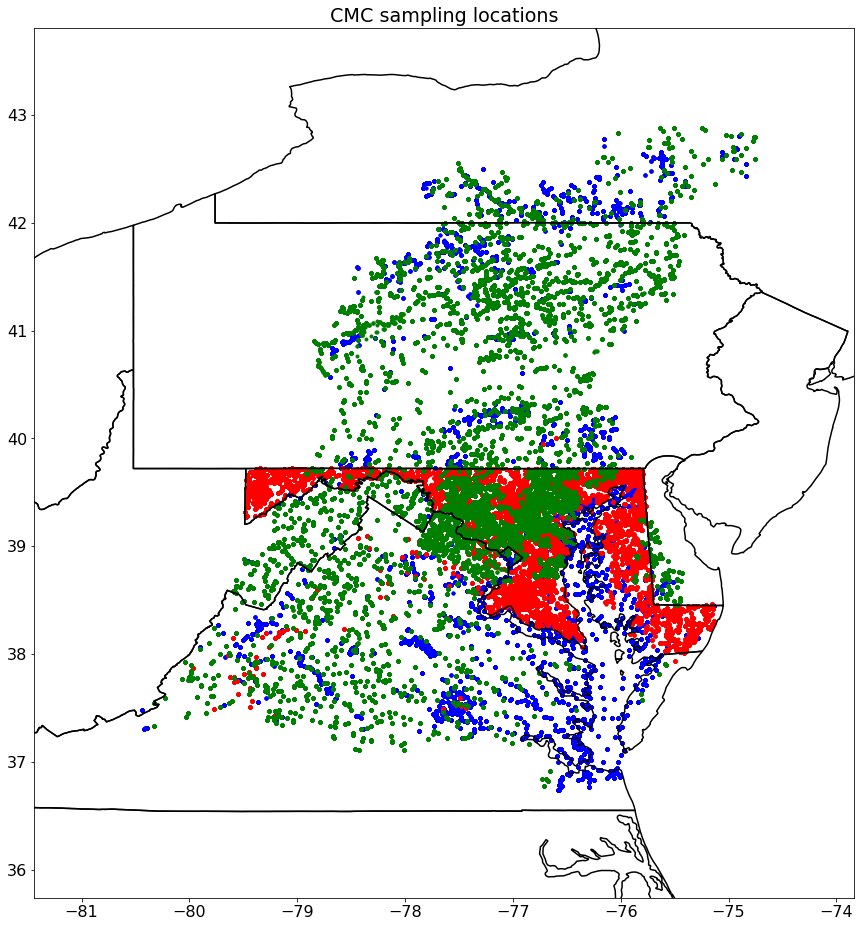

In [11]:
# make a map of sampling locations

plt.rcParams.update({'font.size': 16})

ax = us_states.boundary.plot(color='black',figsize=[20,16])

waterstations = geo_wq.plot(ax=ax, color='blue',marker='.')
benthicstations = geo_benthic.plot(ax=ax, color='red',marker='.')
cbpstations = geo_cbp.plot(ax=ax, color='green',marker='.')

minx, miny, maxx, maxy = geo_wq.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)
ax.set_title('CMC sampling locations')
# ax.legend(handles=[waterstations, benthicstations], labels=['Water Quality', 'Benthic'])

plt.show()

# code modified from https://github.com/oceanspace/DatabricksHackathon/blob/master/WiDS_Tutorial/Python_Geospatial_WiDS.ipynb

**Note:** some of the stations appear to be close ==> check if river/ stream names correspond to each other in the water quality and benthic data; also check, if latitude/ longitude rounded to two decimal places gets any match